In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Đọc dữ liệu
data1 = pd.read_csv('heart.csv')   # Dữ liệu dạng chữ
data2 = pd.read_csv('heart2.csv')  # Dữ liệu dạng số

# 2. Định nghĩa từ điển ánh xạ (Mapping Dictionary) theo yêu cầu của bạn
# Tôi bổ sung thêm Sex: M=1, F=0 để khớp với chuẩn thường gặp trong heart2.csv
mapping_config = {
    'ChestPainType': {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3},
    'RestingECG':    {'Normal': 0, 'ST': 1, 'LVH': 2},
    'ExerciseAngina':{'Y': 1, 'N': 0},
    'ST_Slope':      {'Up': 0, 'Flat': 1, 'Down': 2},
    'Sex':           {'M': 1, 'F': 0} # Bổ sung để đồng bộ cột Sex
}


In [ ]:

# 3. Tiền xử lý data1 (heart.csv) để biến chữ thành số
df1_clean = data1.copy()

for col, mapping in mapping_config.items():
    # Map dữ liệu theo từ điển, nếu có giá trị lạ không khớp thì sẽ ra NaN
    df1_clean[col] = df1_clean[col].map(mapping)

# Kiểm tra xem có dòng nào bị lỗi (NaN) do map không khớp không
if df1_clean.isnull().sum().sum() > 0:
    print("Cảnh báo: Có giá trị không khớp mapping trong data1. Đã điền 0 hoặc giá trị mặc định.")
    df1_clean = df1_clean.fillna(0) # Xử lý NaN nếu có

# 4. Gộp hai bộ dữ liệu lại thành một (Concatenate)
# Vì data2 đã là số chuẩn rồi, ta gộp trực tiếp
df_final = pd.concat([df1_clean, data2], ignore_index=True)

display(df_final.head())

print(f"Kích thước dữ liệu sau khi gộp: {df_final.shape}")

# 5. Chuẩn bị dữ liệu cho Clustering
# Tách cột HeartDisease (đáp án) ra riêng để đối chiếu sau này
X = df_final.drop('HeartDisease', axis=1)
y_true = df_final['HeartDisease']

# Scale dữ liệu (QUAN TRỌNG: Scale trên toàn bộ dữ liệu đã gộp)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# PHẦN K-MEANS VÀ VẼ BIỂU ĐỒ (Giữ nguyên logic của bạn)
# ---------------------------------------------------------

# 6. Chạy K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 7. Giảm chiều PCA để vẽ
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

# 8. Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', s=60, alpha=0.6)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=300, marker='X', label='Centroids', edgecolors='white')

plt.title(f'Phân cụm dữ liệu Tim mạch (Tổng hợp {len(df_final)} bản ghi)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------------------------------------
# PHẦN ĐÁNH GIÁ (Sửa lại để dùng biến df_final)
# ---------------------------------------------------------

# 1. Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# 2. Thêm nhãn cụm vào dataframe tổng
df_final['Cluster_Result'] = labels

# 3. Cross-tabulation (So sánh với cột HeartDisease thật của cả 2 file gộp lại)
print("\nPhân bố bệnh nhân thực tế (0: Khỏe, 1: Bệnh) trong từng cụm:")
crosstab = pd.crosstab(df_final['Cluster_Result'], df_final['HeartDisease'])
print(crosstab)

# Tính phần trăm
crosstab_pct = pd.crosstab(df_final['Cluster_Result'], df_final['HeartDisease'], normalize='index') * 100
print("\nTỷ lệ phần trăm (%):")
print(crosstab_pct.round(2))

# Vẽ biểu đồ cột chồng
crosstab.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.8)
plt.title('Tỷ lệ Bệnh tim trong từng Cụm (Dữ liệu Gộp)')
plt.xlabel('Cụm (Cluster)')
plt.ylabel('Số lượng bệnh nhân')
plt.legend(['Khỏe (0)', 'Bệnh (1)'])
plt.xticks(rotation=0)
plt.show()

NameError: name 'show' is not defined

1. Silhouette Score (Độ tách biệt): 0.143
------------------------------
2. Phân bố bệnh nhân thực tế trong từng cụm:
HeartDisease      0    1
Cluster_Result          
0                10  178
1               375   51
2                25  279

3. Tỷ lệ phần trăm (%):
HeartDisease        0      1
Cluster_Result              
0                5.32  94.68
1               88.03  11.97
2                8.22  91.78


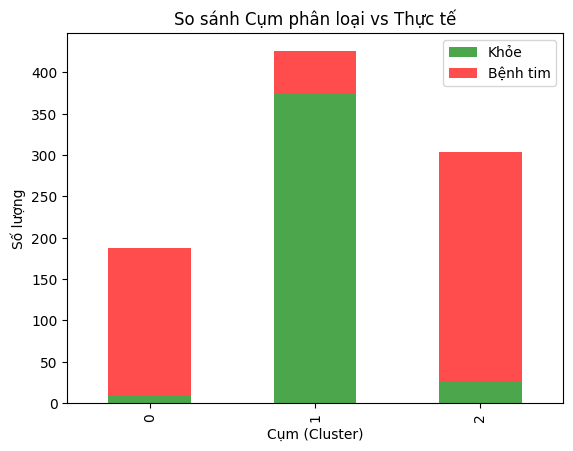

In [38]:
from sklearn.metrics import silhouette_score

# 1. Tính Silhouette Score
sil_score = silhouette_score(X_scaled, labels)
print(f"1. Silhouette Score (Độ tách biệt): {sil_score:.3f}")
print("-" * 30)

# 2. Cross-tabulation (So sánh với bệnh thật)
# Đảm bảo data gốc vẫn còn cột HeartDisease chưa bị encode lung tung
# Nếu cột HeartDisease đã bị encode thì không sao, nhưng phải nhớ 0 là gì, 1 là gì
print("2. Phân bố bệnh nhân thực tế trong từng cụm:")
crosstab = pd.crosstab(data['Cluster_Result'], data['HeartDisease'])
print(crosstab)

# Tính phần trăm bệnh trong mỗi cụm
crosstab_pct = pd.crosstab(data['Cluster_Result'], data['HeartDisease'], normalize='index') * 100
print("\n3. Tỷ lệ phần trăm (%):")
print(crosstab_pct.round(2))

# Vẽ biểu đồ
crosstab.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('So sánh Cụm phân loại vs Thực tế')
plt.xlabel('Cụm (Cluster)')
plt.ylabel('Số lượng')
plt.legend(['Khỏe', 'Bệnh tim'])
plt.show()